In [ ]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
 
import tensorflow as tf
print(tf.__version__)

2.2.0


In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 40kB 2.1MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=7abd4c97db32ef2e670b696283bf9333740d972d3ac43fd66c0250b2ae13edef
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=3f6dd32f037a71e70b163ffc3179140b8f6c718b1d43ce352e17b5dd213aec25
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=3373790ef3fe15c4a929ff0c0c3e893ab4935a9f52d0e0ec414e1a177cf4187a
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.1MB 3.4MB/s 


In [ ]:
import bert
import tensorflow_hub as hub
import pandas as pd

from tensorflow.keras.models import Model

from bert.tokenization.bert_tokenization import FullTokenizer

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

import nltk
from tensorflow.keras.preprocessing.sequence import pad_sequences
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Reading the first dataset
data = pd.read_csv("/content/drive/My Drive/isear.csv", delimiter="|" , error_bad_lines=False)
#data = data.dropna()
df = data.loc[:,'Field1':'SIT']
df = df.drop(['Field3', 'Field2', 'MYKEY'], axis = 1)

emotion_list = df['Field1'].tolist()
sentence_list = df['SIT'].tolist()

len(sentence_list)

b'Skipping line 199: expected 43 fields, saw 44\nSkipping line 222: expected 43 fields, saw 44\nSkipping line 248: expected 43 fields, saw 44\nSkipping line 350: expected 43 fields, saw 44\nSkipping line 395: expected 43 fields, saw 44\nSkipping line 423: expected 43 fields, saw 44\nSkipping line 480: expected 43 fields, saw 44\nSkipping line 552: expected 43 fields, saw 44\nSkipping line 601: expected 43 fields, saw 45\nSkipping line 604: expected 43 fields, saw 45\nSkipping line 612: expected 43 fields, saw 45\nSkipping line 722: expected 43 fields, saw 44\nSkipping line 765: expected 43 fields, saw 44\nSkipping line 800: expected 43 fields, saw 46\nSkipping line 818: expected 43 fields, saw 45\nSkipping line 891: expected 43 fields, saw 44\nSkipping line 928: expected 43 fields, saw 44\nSkipping line 963: expected 43 fields, saw 44\nSkipping line 965: expected 43 fields, saw 45\nSkipping line 974: expected 43 fields, saw 44\nSkipping line 985: expected 43 fields, saw 44\nSkipping li

7503

In [ ]:
#Reading the second dataset
data2 = pd.read_csv("/content/drive/My Drive/text_emotion.csv")
data2 = data2.dropna()
emotion_list2 = data2['sentiment'].tolist()
sentence_list2 = data2['content'].tolist()

emotion_list2_unique = data2['sentiment'].unique().tolist()

#Joining the two datasets
final_emotion_list = emotion_list + emotion_list2
final_sentence_list = sentence_list + sentence_list2

print(len(emotion_list2))

print(len(final_emotion_list))
print(len(final_sentence_list))

40000
47503
47503


In [ ]:
#remove stopwords
for word in STOPWORDS:
    token = ' ' + word + ' '
    res = list(map(lambda token: str.replace(token, ' ', ' '), final_sentence_list))


#filter sentence
sentenceFiltered = []
for w in final_sentence_list:
    if w not in STOPWORDS:
        sentenceFiltered.append(w)

In [ ]:
dataLabels = {'joy':0, 'fear':1, 'anger':2, 'sadness':3, 'disgust':4, 'shame':5, 'guilt':6, 'empty':7,
       'enthusiasm':8, 'neutral':9, 'worry':10, 'surprise':11, 'love':12, 'fun':13, 'hate':14, 'happiness':15,
       'boredom':16, 'relief':17}

#Maps the label to a specific integer
labelList = [dataLabels[item] for item in final_emotion_list]


In [ ]:
#Shuffling the dataset
#import random
#from random import Random
#Random(10).shuffle(final_sentence_list)
#Random(10).shuffle(labelList)

In [ ]:
#Most frequent 5000 words in the dataset
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = 0.8

#labelsTensor = tf.Variable(labelList, tf.int32)
#encoded_tensor = tf.one_hot(labelsTensor, 18)

ys = tf.keras.utils.to_categorical(labelList, num_classes=18)

train_size = int(len(sentenceFiltered) * training_portion)
train_articles = sentenceFiltered[0: train_size]
train_labels = ys[0: train_size]

validation_articles = sentenceFiltered[train_size:]
validation_labels = ys[train_size:]

In [ ]:
ys[1001]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [ ]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

def tokenize_sentences(sentence):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence))

In [ ]:
train_sequences = [tokenize_sentences(sentence) for sentence in train_articles]
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = [tokenize_sentences(sentence) for sentence in validation_articles]
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
import numpy as np
train_x = np.asarray(train_padded)
train_y = np.asarray(train_labels)
validation_x = np.asarray(validation_padded)
validation_y = np.asarray(validation_labels)

In [ ]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=18,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = tf.keras.layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = tf.keras.layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = tf.keras.layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = tf.keras.layers.GlobalMaxPool1D()
        
        self.dense_1 = tf.keras.layers.Dense(units=dnn_units, activation="relu")
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = tf.keras.layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = tf.keras.layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [ ]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 18

DROPOUT_RATE = 0.2

NB_EPOCHS = 10


text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [ ]:
text_model.compile(loss="categorical_crossentropy",
                       optimizer="rmsprop",
                       metrics=["accuracy"])

In [ ]:
history = text_model.fit(train_x, train_y, epochs=NB_EPOCHS, validation_data=(validation_x, validation_y), verbose=2)

Epoch 1/10
1188/1188 - 53s - loss: 1.9962 - accuracy: 0.3099 - val_loss: 1.9699 - val_accuracy: 0.3538
Epoch 2/10
1188/1188 - 53s - loss: 1.6928 - accuracy: 0.4213 - val_loss: 1.9828 - val_accuracy: 0.3535
Epoch 3/10
1188/1188 - 53s - loss: 1.4630 - accuracy: 0.5022 - val_loss: 2.0268 - val_accuracy: 0.3434
Epoch 4/10
1188/1188 - 53s - loss: 1.1421 - accuracy: 0.6178 - val_loss: 2.2204 - val_accuracy: 0.3296
Epoch 5/10
1188/1188 - 53s - loss: 0.7977 - accuracy: 0.7411 - val_loss: 2.7656 - val_accuracy: 0.3062
Epoch 6/10
1188/1188 - 53s - loss: 0.5116 - accuracy: 0.8351 - val_loss: 3.5907 - val_accuracy: 0.2892
Epoch 7/10
1188/1188 - 52s - loss: 0.3383 - accuracy: 0.8931 - val_loss: 4.1470 - val_accuracy: 0.2378
Epoch 8/10
1188/1188 - 53s - loss: 0.2383 - accuracy: 0.9258 - val_loss: 4.8757 - val_accuracy: 0.2424
Epoch 9/10
1188/1188 - 53s - loss: 0.1784 - accuracy: 0.9467 - val_loss: 5.6249 - val_accuracy: 0.2413
Epoch 10/10
1188/1188 - 53s - loss: 0.1452 - accuracy: 0.9571 - val_loss:

In [ ]:
text_model.summary()

Model: "text_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  6104400   
_________________________________________________________________
conv1d_3 (Conv1D)            multiple                  40100     
_________________________________________________________________
conv1d_4 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_5 (Conv1D)            multiple                  80100     
_________________________________________________________________
global_max_pooling1d_1 (Glob multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  77056     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0

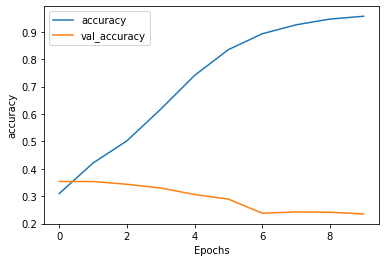

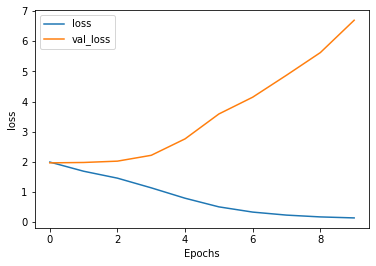

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
txt = "I don't really feel like working right now."
seq = [tokenize_sentences(txt)]

padded = pad_sequences(seq, maxlen=max_length)
pred = text_model.predict(padded)

new_data ={j:i for i, j in dataLabels.items()}

print(pred, new_data[int(pred.argmax(1))])

[[1.56054458e-11 6.22265628e-10 5.05404607e-10 9.94750202e-01
  2.00931177e-12 6.09965800e-10 3.30255268e-10 2.58218389e-08
  3.28555316e-09 8.58090236e-04 4.38019121e-03 2.37760034e-07
  8.61164699e-06 1.06967875e-08 2.03960576e-06 6.44828503e-07
  2.05862083e-09 1.16946453e-08]] sadness


In [ ]:
text_model.save("text_model_2")

NotImplementedError: ignored

In [ ]:
from tensorflow import keras

reconstructed_model = keras.models.load_model("/content/drive/My Drive/text_model_1")

In [ ]:
txt = "Great is thy faithfulness"
max_length = 200
seq = [tokenize_sentences(txt)]

padded = pad_sequences(seq, maxlen=max_length)
#print(padded)
pred = reconstructed_model.predict(padded)

#reconstructed_model.predict(np.asarray(padded))

new_data ={j:i for i, j in dataLabels.items()}

print(pred, new_data[int(pred.argmax(1))])

[[1.23299565e-03 1.44403466e-05 1.53080822e-04 1.40817985e-02
  8.54668451e-06 7.50408844e-06 1.72525797e-05 1.49668823e-03
  1.85970422e-02 2.54019033e-02 3.23354229e-02 1.40482839e-02
  2.57990867e-01 2.72205081e-02 7.90514052e-04 4.70834464e-01
  2.60939069e-05 1.35742560e-01]] happiness


In [ ]:
from google.colab import files
#For the folder you have to zip it first and can only download later on
#/content/text_model_1
!zip -r model_2.zip /content/text_model_2
#Download files
files.download('model_2.zip')

  adding: content/text_model_2/ (stored 0%)
  adding: content/text_model_2/variables/ (stored 0%)
  adding: content/text_model_2/variables/variables.index (deflated 65%)
  adding: content/text_model_2/variables/variables.data-00000-of-00002 (deflated 31%)
  adding: content/text_model_2/variables/variables.data-00001-of-00002 (deflated 9%)
  adding: content/text_model_2/saved_model.pb (deflated 89%)
  adding: content/text_model_2/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size, and output embedding dimension of size we set at the top
    tf.keras.layers.Embedding(len(tokenizer.vocab), 64),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMB_DIM)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(EMB_DIM, activation='relu'),
    # Add a Dense layer with 18 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(18, activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          1953408   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_8 (Dense)              (None, 200)               25800     
_________________________________________________________________
dense_9 (Dense)              (None, 18)                3618      
Total params: 2,048,874
Trainable params: 2,048,874
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])

In [ ]:
history2 = model.fit(train_x, train_y, epochs=NB_EPOCHS, validation_data=(validation_x, validation_y), verbose=2)

Epoch 1/5
1188/1188 - 38s - loss: 2.0835 - accuracy: 0.2644 - val_loss: 2.0818 - val_accuracy: 0.2915
Epoch 2/5
1188/1188 - 38s - loss: 1.8124 - accuracy: 0.3682 - val_loss: 2.0397 - val_accuracy: 0.3093
Epoch 3/5
1188/1188 - 39s - loss: 1.6140 - accuracy: 0.4459 - val_loss: 1.9971 - val_accuracy: 0.3385
Epoch 4/5
1188/1188 - 39s - loss: 1.4200 - accuracy: 0.5197 - val_loss: 2.1736 - val_accuracy: 0.3153
Epoch 5/5
1188/1188 - 39s - loss: 1.2355 - accuracy: 0.5870 - val_loss: 2.3775 - val_accuracy: 0.3162


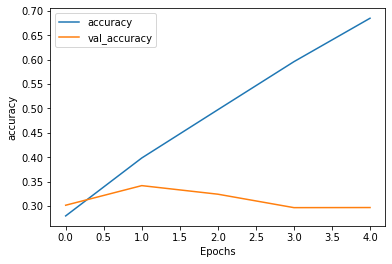

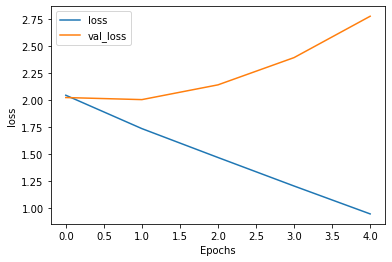

In [ ]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

In [ ]:
txt = "I am tired because I had a long day"
seq = [tokenize_sentences(txt)]

padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)

new_data ={j:i for i, j in dataLabels.items()}

print(pred, new_data[int(pred.argmax(1))])

[[0.00343048 0.00312649 0.00420371 0.03671944 0.0028361  0.00459542
  0.00202645 0.14532387 0.01742799 0.6422182  0.04894297 0.01172255
  0.01459595 0.01034112 0.00528941 0.01159973 0.00716241 0.02843775]] neutral
